## PART III - PREDICTION


# Poverty Prediction Model


The objective of this task is predict from household surveys if a household is poor or not.


![alt text](fig/intro.png "Title")

In [1]:
# I checked warnings, but for the final report I prefer ignore those 
#that really does not affect the results (warnings of libraries, etc)
import warnings
warnings.simplefilter('ignore')

# avoid kernel crash
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
# Load the functions that are necessary for the task
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# For the graPhics
sns.set(font_scale=1.5)

In [3]:
# Sometimes I will use R functions (those I believe are the best ones)
# Load in the r magic
%load_ext rpy2.ipython
%R require(ggplot2)
%R require(dplyr)
%R require(data.table)
%R require(cowplot)

# own functions 
%R source('utils/Rgraphs.R')

R object with classes: ('list',) mapped to:
<ListVector - Python:0x7fe370edb648 / R:0x555b906ab758>
[SignatureTranslatedFunc..., BoolVector]
  value: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  R object with classes: ('function',) mapped to:
<SignatureTranslatedFunction - Python:0x7fe370edb3c8 / R:0x555b8f14df38>
  visible: <class 'rpy2.robjects.vectors.BoolVector'>
  R object with classes: ('logical',) mapped to:
<BoolVector - Python:0x7fe370ed8f88 / R:0x555b8ce31e68>
[       0]

In [4]:
# my own functions
# watch for any changes in the utils module, and reload it automatically
%load_ext autoreload
%autoreload 2
# load my own functions
from utils.prepare_data import *
from utils.proc_train_models import *

## Description of the dataset

![alt text](fig/data.png)

In [5]:
# Load the data
#Training
dataset = read_csv('data/Exercise_train.csv', sep=',', header=0, low_memory=False)
dataset = dataset.iloc[:, 1:11]
datatest = read_csv('data/Exercise_test.csv', sep=',', header=0, low_memory=False)
datatest = datatest.iloc[:, 1:11]
print('Number of households in the training set: ' + str(dataset.shape[0]))
print('Number of households in the test set: ' + str(datatest.shape[0]))

print('Percent of households in the training set: ' + str((dataset.shape[0]/(dataset.shape[0] + datatest.shape[0])*100)))
print('Percent of households in the test set: ' + str((datatest.shape[0]/(dataset.shape[0] + datatest.shape[0])*100)))

#Test
dataset.head()

Number of households in the training set: 6562
Number of households in the test set: 1641
Percent of households in the training set: 79.99512373521883
Percent of households in the test set: 20.004876264781178


,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [6]:
# Concatenate data
#dataset = pd.concat([dataset, datatest], axis=0)
#del datatest

## BALANCED DATA ?

* 55% of the househols in the dataset are not in poverty and 45% are in poverty.

* The dataset seems pretty much balanced, the proportion of poor and not poor people in the population is close to each other.

Train


poor,False,True
poor,,
False,0.549985,0.000000
True,0.000000,0.450015


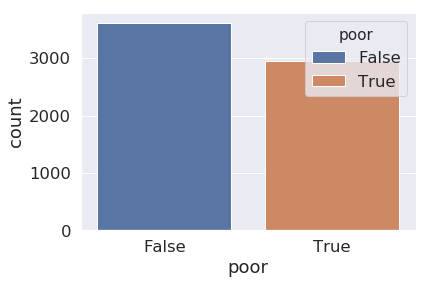

In [7]:
print('Train')
sns.countplot(x='poor', hue='poor',
             data=dataset, dodge=False);
pd.crosstab(dataset['poor'], dataset['poor'],  normalize=True)

In [8]:
#print('Test')
#sns.countplot(x='poor', hue='poor',
#             data=datatest, dodge=False);
#pd.crosstab(datatest['poor'], datatest['poor'],  normalize=True)

## MISSING VARIABLES

We have missing values in the training and testing set. There is a small proportion of missings, between 2-3% 

In [9]:
# Percentage of missings in each variables
missing_train = (dataset.isnull().sum(axis = 0)/dataset.shape[0])*100
missing_test = (datatest.isnull().sum(axis = 0)/datatest.shape[0])*100
#type(missing_train)
#missing_test

#dataset.isnull().sum(axis = 0)

missing_train = missing_train.apply(pd.to_numeric)
missing_train= pd.DataFrame(missing_train)

missing_test = missing_test.apply(pd.to_numeric)
missing_test= pd.DataFrame(missing_test)


In [10]:
%%R -w 900 -h 480 -u px
## %%R -w 900 -h 480 -u px

plot_grid(HeatMaps.Nas(missing_train, label = 'Train'), HeatMaps.Nas(missing_test, label = 'Test'), labels = "AUTO")


Error in row.names(dt.values) : object 'missing_train' not found


## CONTINOUS VARIABLES 

Looking the continous variables, we can also see:

* There are missing values
* There are extreme values (outliers) in the variables: omtioxzz and yfmzwkru, that should be corrected. We detect outliers when we see the following patterns:

    * There are not others points close to this extreme value.
    * The extreme value is greater than the mean + 3 standard deviations (normal).
    * The extreme value create distortions in the data.

* It seems that the continous variables show differences between poor and not poor, these variables will contribute to our analysis.

# TRAINING


In [11]:
# training
dataset.iloc[:,1:10].describe()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6361.000000,6353.000000,6355.000000,6366.000000
mean,17.455117,-2.826696,-4.194335,-7.461828
std,10.924393,12.615775,4.476410,11.198626
min,-127.000000,-4.000000,-31.000000,-74.500000
25%,12.000000,-4.000000,-7.000000,-14.500000
50%,12.000000,-3.000000,-3.000000,-4.500000
75%,21.000000,-2.000000,-1.000000,0.500000
max,111.000000,1000.000000,3.000000,10.500000


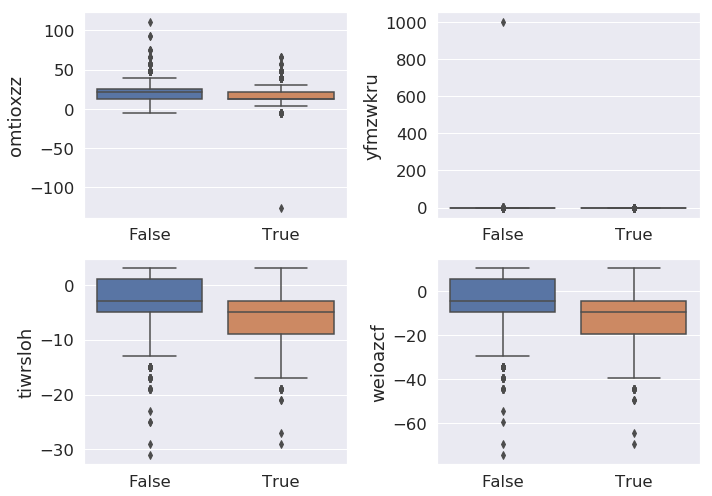

In [12]:
import matplotlib.pyplot as plt
df_numeric= dataset
df_numeric['poor'] = df_numeric['poor'].astype('float')
df_numeric = df_numeric.select_dtypes(include=[np.float])
df_numeric['poor'] = df_numeric['poor'].astype('bool')

col = df_numeric.columns[:-1]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
for idx, feat in enumerate(col): 
    ax = axes[int(idx / 2), idx % 2] 
    sns.boxplot(x='poor', y=feat, data=df_numeric, ax=ax) 
    ax.set_xlabel('') 
    ax.set_ylabel(feat) 
fig.tight_layout();

### FIX EXTREME VALUES

If we fix the outliers, we can see the distribution of the variables clearly.

In [13]:
# Fix the extreme values 
x = df_numeric['yfmzwkru'].nlargest(2) 
x = pd.DataFrame(x)
out_max = x.max()
next_value = x.min()
dataset.loc[df_numeric['yfmzwkru'] >= out_max[0], 'yfmzwkru'] = next_value[0]

x = df_numeric['omtioxzz'].nsmallest(2) 
x = pd.DataFrame(x)
out_min = x.min()
next_value = x.max()
dataset.loc[df_numeric['omtioxzz'] == out_min[0], 'omtioxzz'] = next_value[0]

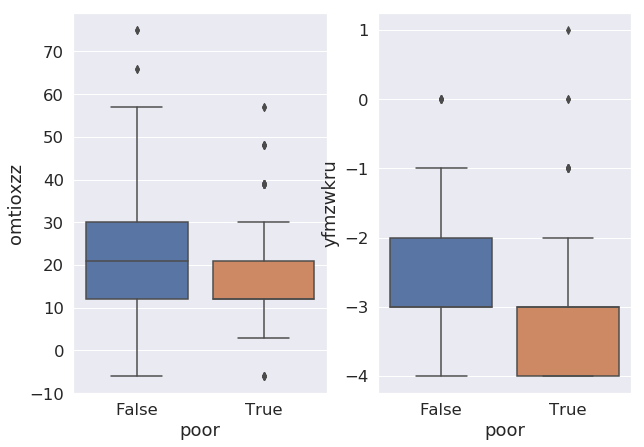

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
sns.boxplot(x='poor', y='omtioxzz', data=datatest, ax=axes[0]) 
sns.boxplot(x='poor', y='yfmzwkru', data=datatest,  ax=axes[1]) 

# TEST

In the test set we do not observe extreme values like we saw in the training set.

In [15]:
datatest.iloc[:,1:10].describe()

,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,1587.000000,1597.000000,1601.000000,1579.000000
mean,17.523629,-2.997495,-4.188007,-7.511400
std,10.724977,0.883570,4.453679,11.150707
min,-6.000000,-4.000000,-23.000000,-54.500000
25%,12.000000,-4.000000,-7.000000,-14.500000
50%,12.000000,-3.000000,-3.000000,-4.500000
75%,21.000000,-2.000000,-1.000000,0.500000
max,75.000000,1.000000,3.000000,10.500000


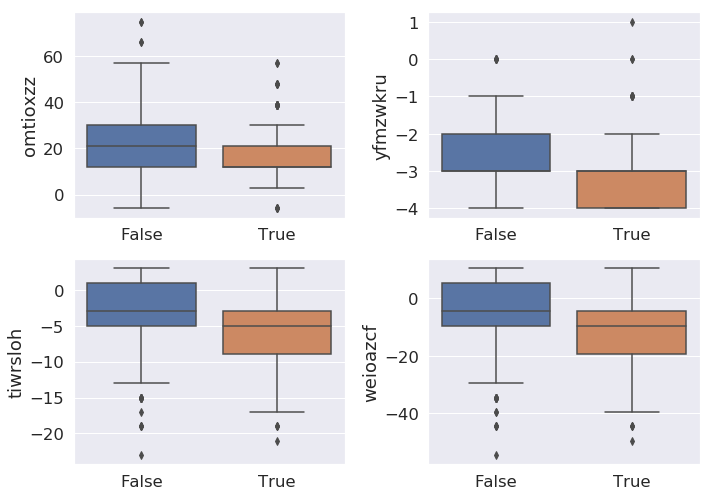

In [16]:
import matplotlib.pyplot as plt
df_numeric= datatest
df_numeric['poor'] = df_numeric['poor'].astype('float')
df_numeric = df_numeric.select_dtypes(include=[np.float])
df_numeric['poor'] = df_numeric['poor'].astype('bool')

col = df_numeric.columns[:-1]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
for idx, feat in enumerate(col): 
    ax = axes[int(idx / 2), idx % 2] 
    sns.boxplot(x='poor', y=feat, data=df_numeric, ax=ax) 
    ax.set_xlabel('') 
    ax.set_ylabel(feat) 
fig.tight_layout();

## CORRELATIONS: CONTINOUS VARIABLES + ITERACTIONS



* We will explore interactions between continuous variables, in order to see if we can get more information, that help us to improve our predictions.

* We well see which variables have high correlation with the variable we want to predict
* We want to avoid multicolineallity, for this we eliminate those explanatory variables that have high correlations between them.

In [17]:
# INTERACTIONS 
#df[‘interaction’] = df[feature_A] * df[feature_B]
dataset['inter_1'] = dataset['yfmzwkru'] * dataset['omtioxzz']
dataset['inter_2'] = dataset['yfmzwkru'] * dataset['tiwrsloh']
dataset['inter_3'] = dataset['yfmzwkru'] * dataset['weioazcf']
dataset['inter_4'] = dataset['omtioxzz'] * dataset['tiwrsloh']
dataset['inter_5'] = dataset['omtioxzz'] * dataset['weioazcf']
dataset['inter_6'] = dataset['tiwrsloh'] * dataset['weioazcf']

numeric = ['yfmzwkru', 'omtioxzz', 'tiwrsloh', 'weioazcf', 'poor', 'inter_1', 'inter_2', 'inter_3', 
           'inter_4', 'inter_5', 'inter_6']
df_cor = dataset.loc[:, numeric]

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 11 Text xticklabel objects>)

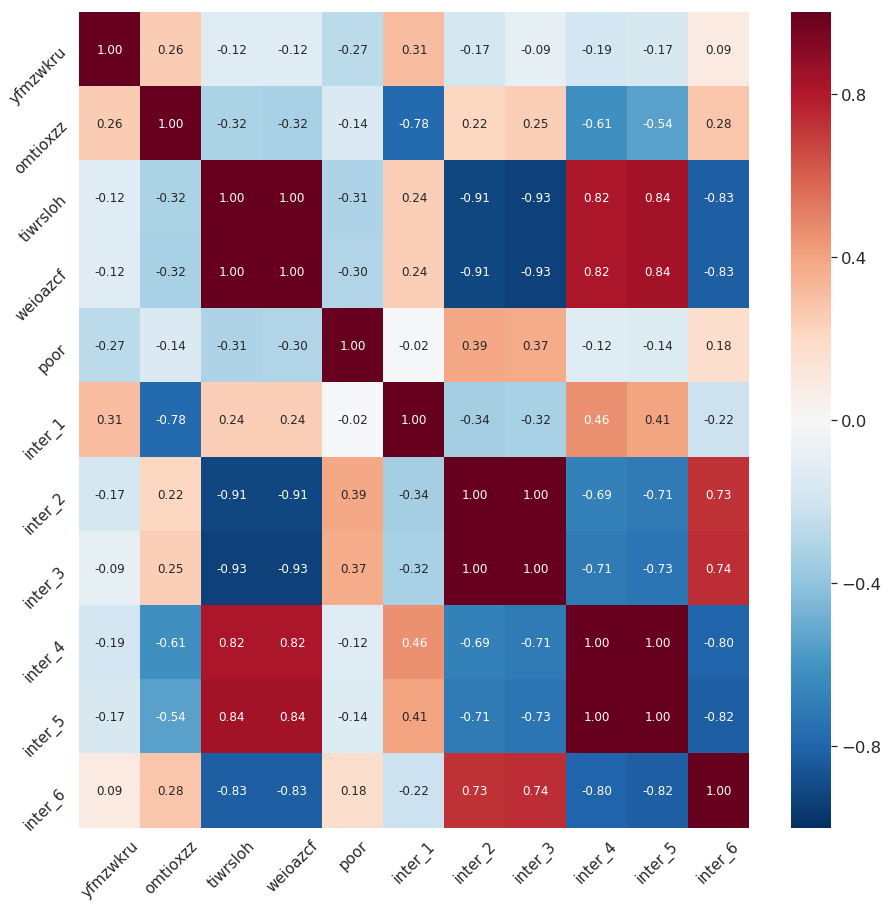

In [18]:
cr = compute_correlation_matrix(df_cor)
fig, ax = plt.subplots(figsize=(15,15))
b = sns.heatmap(cr,  vmin = -1, vmax = 1, center = 0, annot=True, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
b.tick_params(labelsize=15)
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 

We can see some non-linear patterns in the interactions.

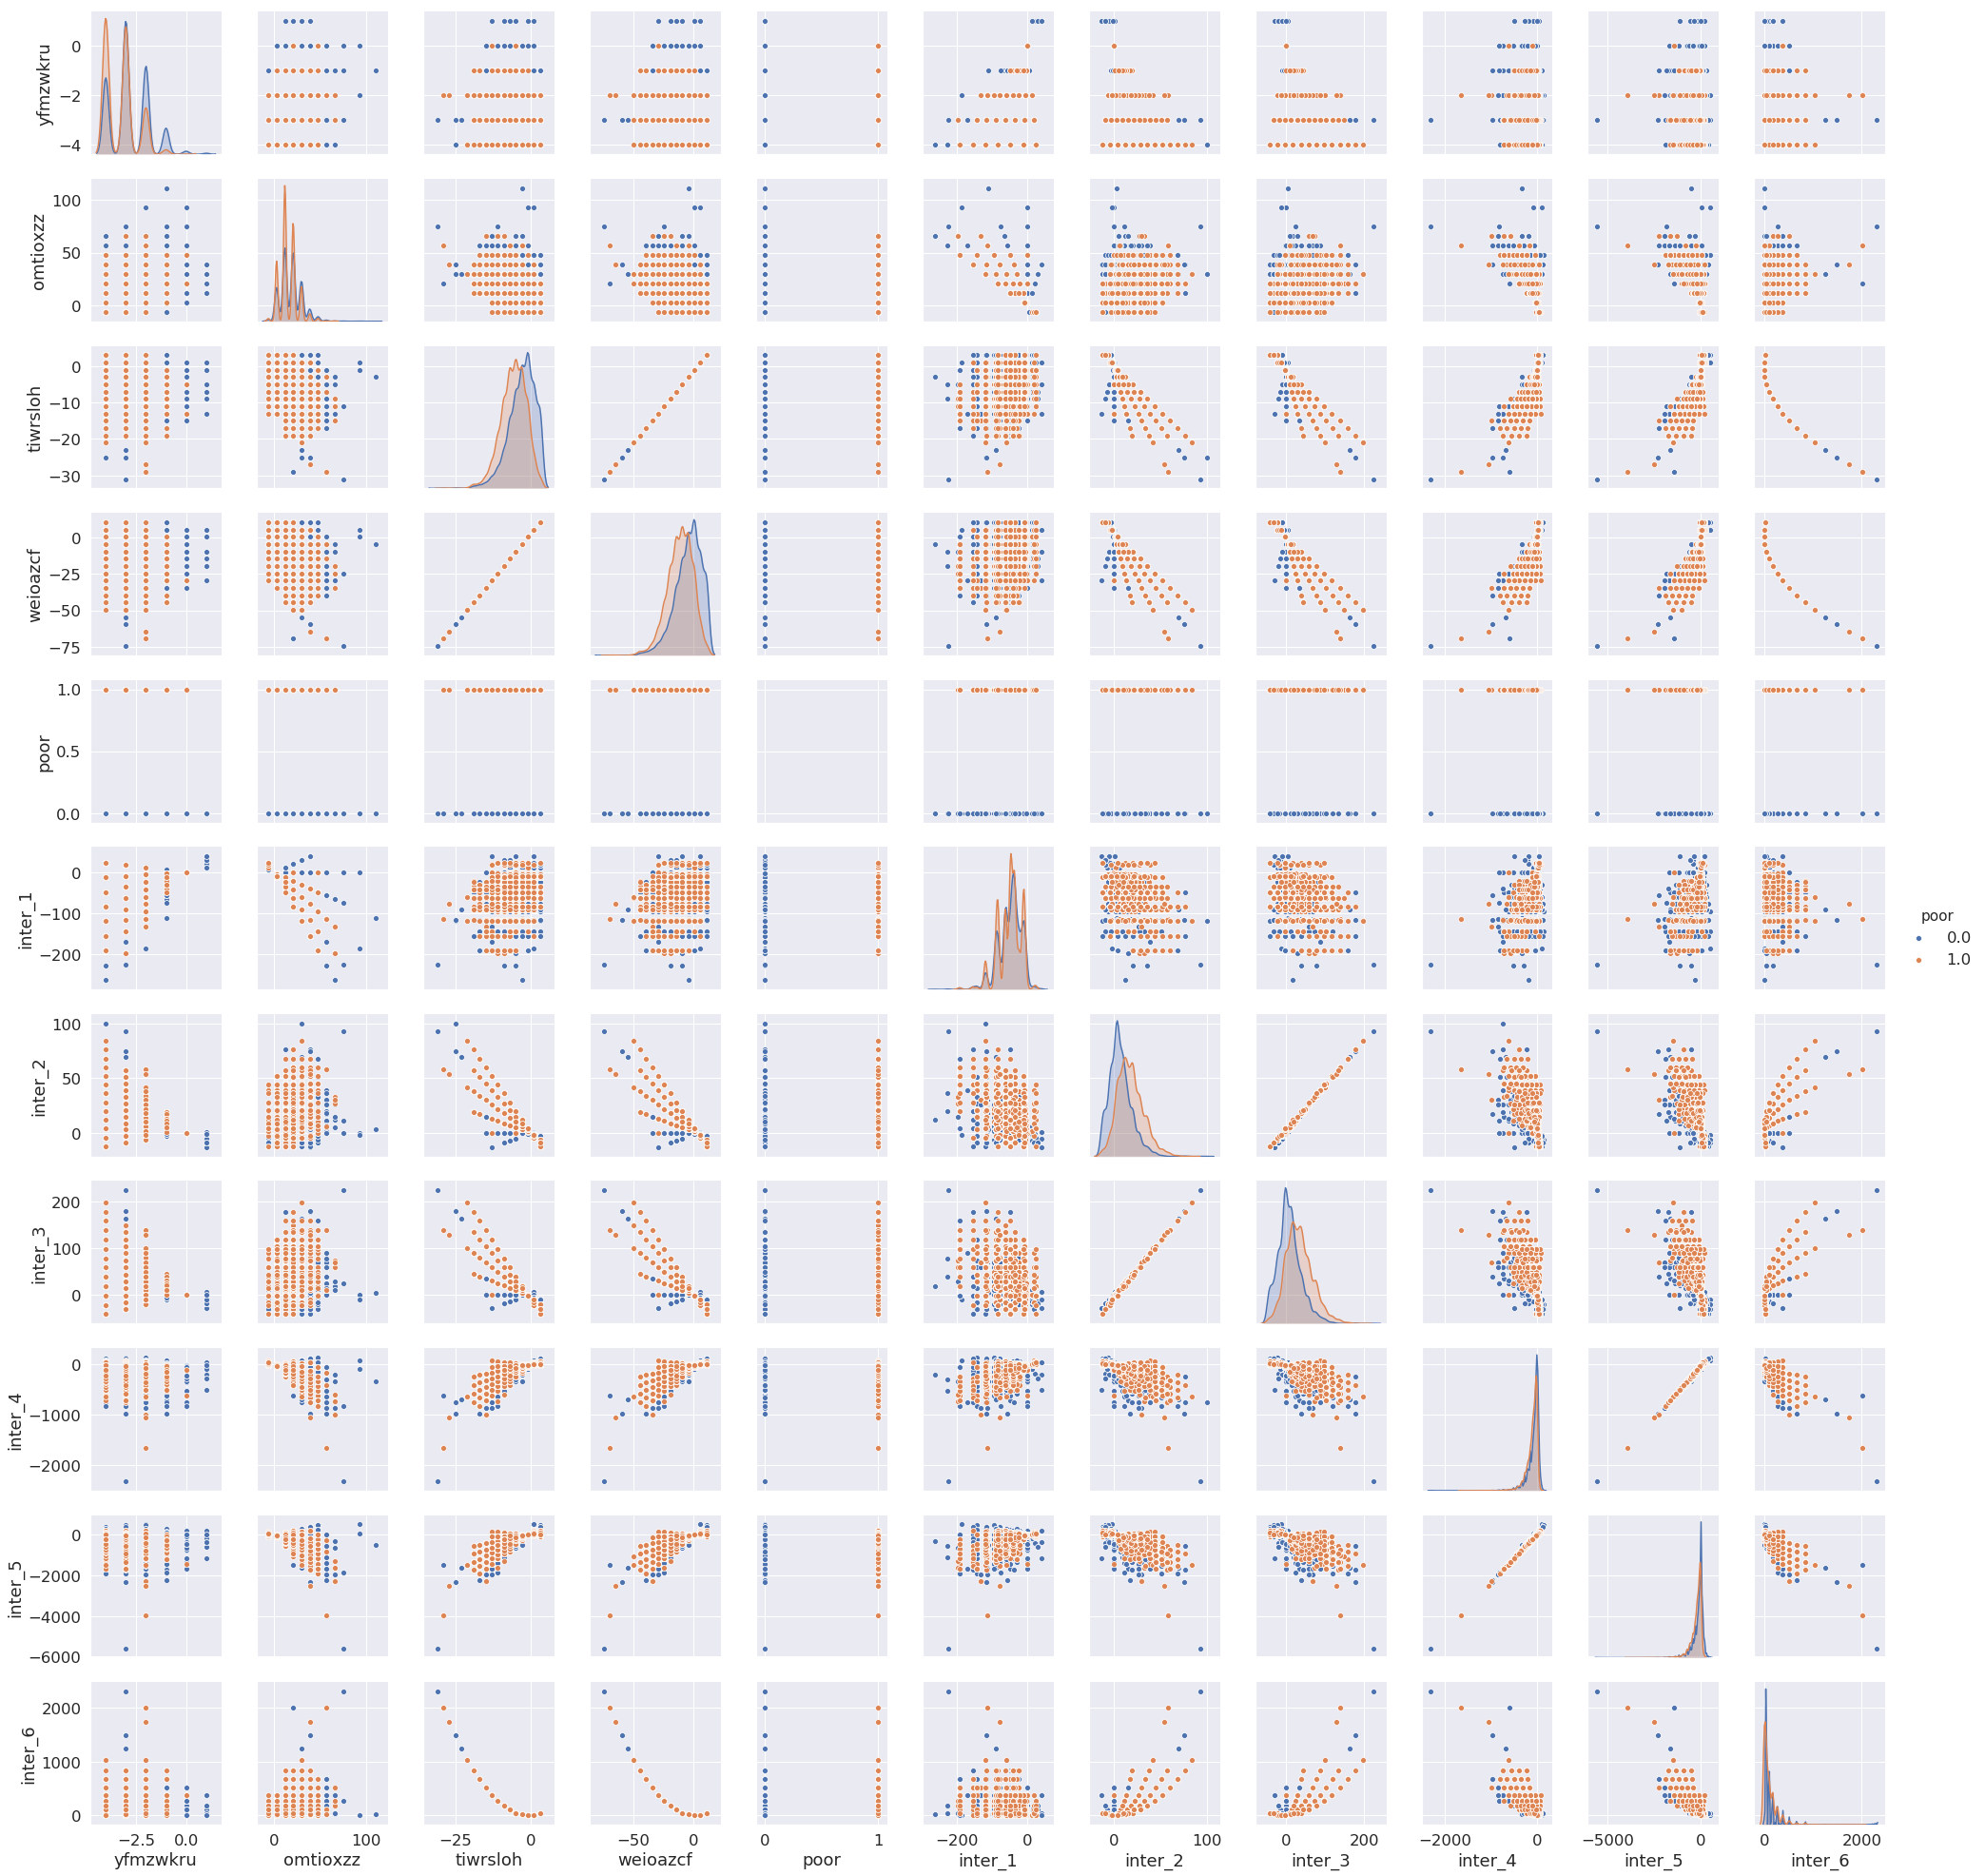

In [19]:
# numerical variables
sns.pairplot(df_cor, hue="poor")#



![alt text](fig/cat.png "Title")


## CATEGORICAL VARIABLES 

Looking the summary of the categorical variables, it is clear that 
* We have variables with na's (this is observed in the differences in count), 
* Also the categories in the variables are between 5 to 31. This would mean an increase in the number of variables when we transform them to binary.
* The majority class in the variable poor is False with 3609 rows, that represents aprox. 54% of the total. It seems that the target in our model would be balanced.

In [20]:
#categorical
dataset.describe(include=['object', 'bool'])

,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk
count,6366,6357,6381,6364
unique,8,6,5,31
top,qzGkS,THHLT,DtMvg,sPNOc
freq,2072,3095,3095,314


## COMPLETE MISSING VALUES IN CATEGORICAL VARIABLES 

In order to consider the missing categorical values in the analysis, we set as 'MISSING' the na's values in the variables. Later, we'll indicate the options that we have to fill this variables.


In [21]:
# insert values in categorical variables 
dataset.kjkrfgld.fillna('MISSING',inplace = True)
dataset.bpowgknt.fillna('MISSING',inplace = True)
dataset.raksnhjf.fillna('MISSING',inplace = True)
dataset.vwpsxrgk.fillna('MISSING',inplace = True)

### DISTRIBUTION  OF POOR & NON POOR 

Here, we can see for each variable the distributions of poor/no poor for each category in each variable. This can be useful to group categories, but right now we only use it as descriptive analysis. The black horizontal line is the percentage of houses classified as **poor**.

In [22]:
dataset['poor'] = dataset['poor'].astype('bool')
var = 'raksnhjf'
target = 'poor'
raksnhjf_count = group_var_target(dataset, target, var)

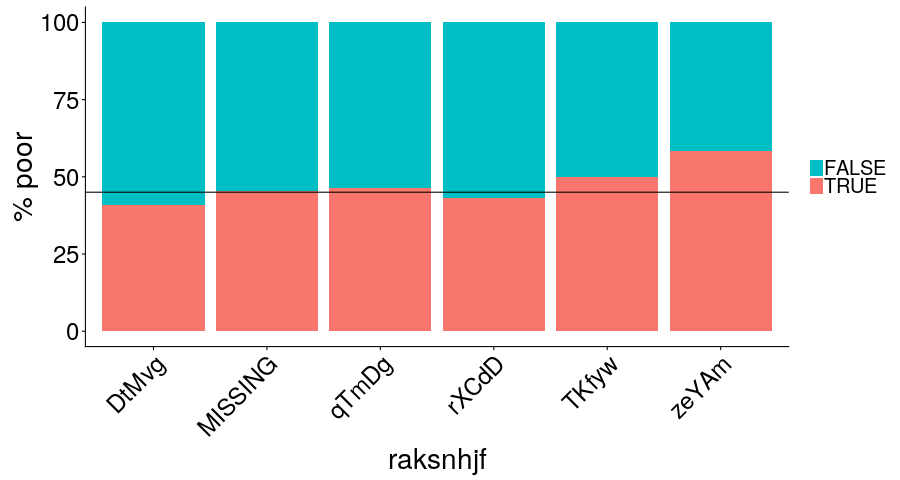

In [23]:
%%R -i raksnhjf_count -w 900 -h 480 -u px
tam = 2
d <- ggplot(data=raksnhjf_count, aes(x = raksnhjf, y = count*100, fill = poor), color = 'black') + geom_bar(stat = "identity") +
geom_hline(yintercept = 45, color = 'black')
d <- d + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
d <- d + theme(axis.title.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.x = element_text(size = rel(tam)))
d <- d + theme(axis.title.x = element_text(size = rel(tam)))
d <- d + theme(legend.text = element_text(size = tam*10))
d <- d + theme(legend.title = element_text(size = tam*10)) + theme(legend.title=element_blank())
d <- d + scale_fill_manual("legend", values = c("FALSE" = "#00BFC4", "TRUE" = "#F8766D")) + ylab("% poor")
print(d)
ggsave('fig/raksnhjf_count.png')

For the variable **raksnhjf** we can see that the different categories appears to be equalliy distributed with the exception of TKfyw and zeYAm

In [24]:
dataset['poor'] = dataset['poor'].astype('bool')
var = 'vwpsxrgk'
target = 'poor'
vwpsxrgk_count = group_var_target(dataset, target, var)
#vwpsxrgk_count.head()

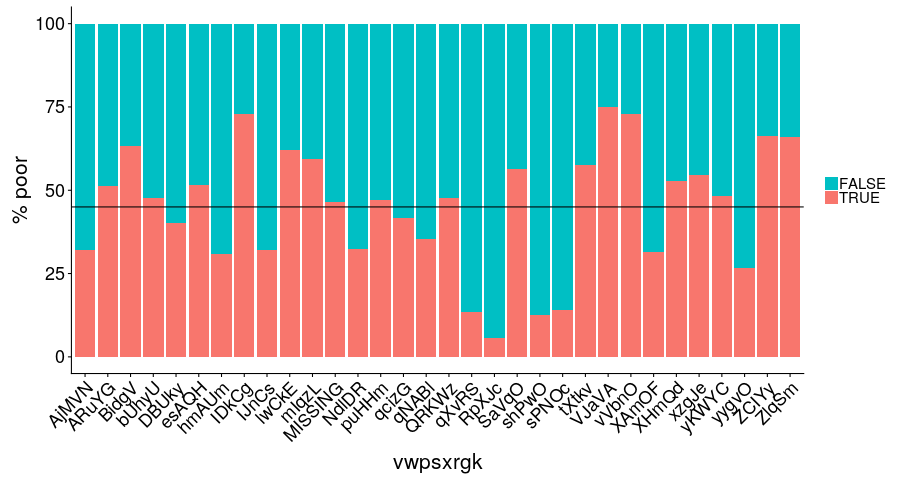

In [25]:
%%R -i vwpsxrgk_count -w 900 -h 480 -u px
tam = 1.5
d <- ggplot(data=vwpsxrgk_count, aes(x = vwpsxrgk, y = count*100, fill = poor), color = 'black') + 
geom_bar(stat = "identity") +
geom_hline(yintercept = 45, color = 'black')
d <- d + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
d <- d + theme(axis.title.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.x = element_text(size = rel(tam)))
d <- d + theme(axis.title.x = element_text(size = rel(tam)))
d <- d + theme(legend.text = element_text(size = tam*10))
d <- d + theme(legend.title = element_text(size = tam*10)) + theme(legend.title=element_blank())
d <- d + scale_fill_manual("legend", values = c("FALSE" = "#00BFC4", "TRUE" = "#F8766D")) + ylab("% poor")
print(d)
ggsave('fig/vwpsxrgk_count.png')

For the variable **vwpsxrgk** we can see that there are rare categories that could be aggregated together.

In [26]:
dataset['poor'] = dataset['poor'].astype('bool')
var = 'kjkrfgld'
target = 'poor'
kjkrfgld_count = group_var_target(dataset, target, var)

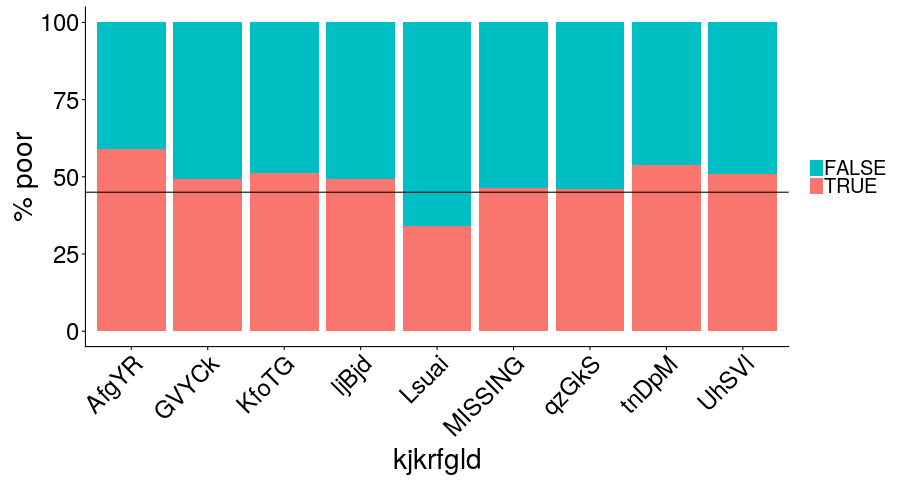

In [27]:
%%R -i kjkrfgld_count -w 900 -h 480 -u px
tam = 2
d <- ggplot(data=kjkrfgld_count, aes(x = kjkrfgld, y = count*100, fill = poor), color = 'black') + geom_bar(stat = "identity") +
geom_hline(yintercept = 45, color = 'black')
d <- d + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
d <- d + theme(axis.title.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.x = element_text(size = rel(tam)))
d <- d + theme(axis.title.x = element_text(size = rel(tam)))
d <- d + theme(legend.text = element_text(size = tam*10))
d <- d + theme(legend.title = element_text(size = tam*10)) + theme(legend.title=element_blank())
d <- d + scale_fill_manual("legend", values = c("FALSE" = "#00BFC4", "TRUE" = "#F8766D")) + ylab("% poor")
print(d)
ggsave('fig/kjkrfgld_count.png')

For the variable **kjkrfgld** we can see that the different categories appears to be equalliy distributed with the exception of AfgYR

In [28]:
dataset['poor'] = dataset['poor'].astype('bool')
var = 'bpowgknt'
target = 'poor'
bpowgknt_count = group_var_target(dataset, target, var)

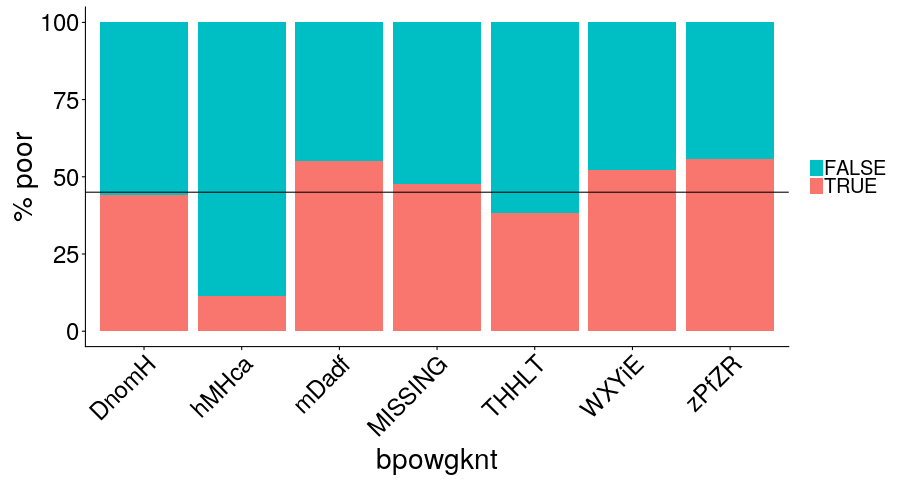

In [29]:
%%R -i bpowgknt_count -w 900 -h 480 -u px
tam = 2
d <- ggplot(data=bpowgknt_count, aes(x = bpowgknt, y = count*100, fill = poor), color = 'black') + geom_bar(stat = "identity") +
geom_hline(yintercept = 45, color = 'black')
d <- d + theme(axis.text.x = element_text(angle = 45, hjust = 1)) 
d <- d + theme(axis.title.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.y = element_text(size = rel(tam)))
d <- d + theme(axis.text.x = element_text(size = rel(tam)))
d <- d + theme(axis.title.x = element_text(size = rel(tam)))
d <- d + theme(legend.text = element_text(size = tam*10))
d <- d + theme(legend.title = element_text(size = tam*10)) + theme(legend.title=element_blank())
d <- d + scale_fill_manual("legend", values = c("FALSE" = "#00BFC4", "TRUE" = "#F8766D")) + ylab("% poor")
print(d)
ggsave('fig/bpowgknt_count.png')

## Categorical treatmens

### Chi Square Test

* The Chi-Square test of independence is a statistical test to determine if there is a significant relationship between 2 categorical variables.  In simple words, the Chi-Square statistic will test whether there is a significant difference in the observed vs the expected frequencies of both variables. 

* We want to see if our categorical variables is related with the variable we wanto to predict.

In [30]:
#Chi Square Feature selection
#Initialize ChiSquare Class
cT = ChiSquare(dataset)
testColumns = ['kjkrfgld', 'bpowgknt', 'raksnhjf', 'vwpsxrgk']
for var in testColumns:
    cT.TestIndependence(colX=var,colY="poor" )  

kjkrfgld is IMPORTANT for Prediction
bpowgknt is IMPORTANT for Prediction
raksnhjf is IMPORTANT for Prediction
vwpsxrgk is IMPORTANT for Prediction


In [31]:
dataset_complete = from_categorical_to_dummies(dataset, 'kjkrfgld')
dataset_complete = from_categorical_to_dummies(dataset_complete, 'bpowgknt')
dataset_complete = from_categorical_to_dummies(dataset_complete, 'raksnhjf')
dataset_complete = from_categorical_to_dummies(dataset_complete, 'vwpsxrgk')
#dataset_complete['poor'] = dataset_complete['poor'].astype('bool')
#dataset_complete['poor'] = dataset_complete['poor'].astype('float')

In [32]:
cols = dataset_complete.columns[6:dataset_complete.shape[0]]

### Using the test to eliminate 0-1 variables, we can see that we can eliminate the following variables:

kjkrfgld_GVYCk, kjkrfgld_MISSING, kjkrfgld_qzGkS, kjkrfgld_tnDpM, bpowgknt_MISSING, raksnhjf_qTmDg, raksnhjf_rXCdD,
vwpsxrgk_ARuYG, vwpsxrgk_MISSING, vwpsxrgk_QRKWz,  vwpsxrgk_bUhyU, vwpsxrgk_puHHm, vwpsxrgk_qcizG, vwpsxrgk_yKWYC

In [33]:
# the same test but we the 0-1 variables
cT = ChiSquare(dataset_complete)
testColumns = cols
for var in testColumns:
    cT.TestIndependence(colX=var,colY="poor" )  

inter_1 is IMPORTANT for Prediction
inter_2 is IMPORTANT for Prediction
inter_3 is IMPORTANT for Prediction
inter_4 is IMPORTANT for Prediction
inter_5 is IMPORTANT for Prediction
inter_6 is IMPORTANT for Prediction
kjkrfgld_AfgYR is IMPORTANT for Prediction
kjkrfgld_GVYCk is NOT an important predictor. (Discard kjkrfgld_GVYCk from model)
kjkrfgld_KfoTG is IMPORTANT for Prediction
kjkrfgld_Lsuai is IMPORTANT for Prediction
kjkrfgld_MISSING is NOT an important predictor. (Discard kjkrfgld_MISSING from model)
kjkrfgld_ljBjd is IMPORTANT for Prediction
kjkrfgld_qzGkS is NOT an important predictor. (Discard kjkrfgld_qzGkS from model)
kjkrfgld_tnDpM is NOT an important predictor. (Discard kjkrfgld_tnDpM from model)
bpowgknt_MISSING is NOT an important predictor. (Discard bpowgknt_MISSING from model)
bpowgknt_THHLT is IMPORTANT for Prediction
bpowgknt_WXYiE is IMPORTANT for Prediction
bpowgknt_hMHca is IMPORTANT for Prediction
bpowgknt_mDadf is IMPORTANT for Prediction
bpowgknt_zPfZR is IMPO

## SIMILARITY BETWEEN VARIABLES

**Cosine Similarity**: We wanto to avoid include similar characteristis, so ideally we want the cos(pair of variables) to be as close as possible to 0. In the heatmap of below we can see that there is not variables close to 1 (only in the diagonal).

In [34]:
df = dataset_complete.loc[:, cols]

from scipy.spatial.distance import cosine

tmp = pd.DataFrame(index=df.columns,columns=df.columns)
#tmp.head()
for i in range(0,len(df.columns)) :
    for j in range(0,len(df.columns)) :
        tmp.ix[i,j] = 1-cosine(df.ix[:,i],df.ix[:,j])

tmp = tmp.apply(pd.to_numeric)
#tmp.dtypes


(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5, 54.5]),
 <a list of 28 Text xticklabel objects>)

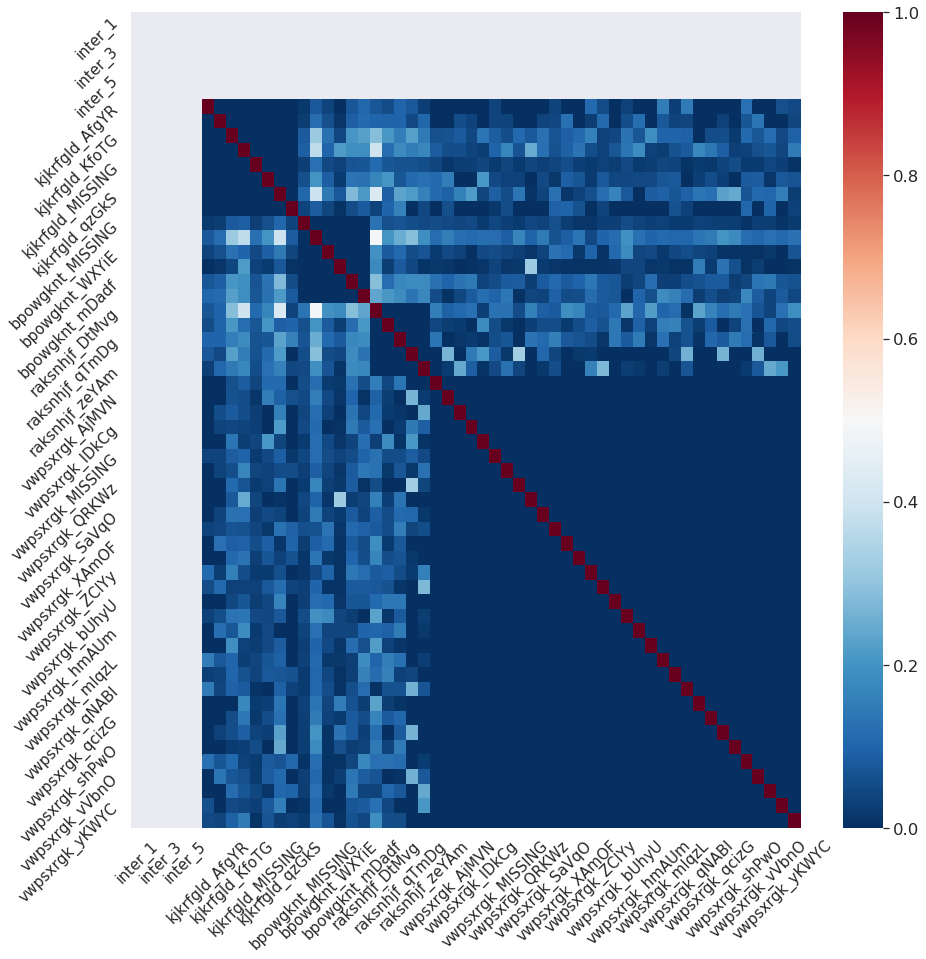

In [35]:
fig, ax = plt.subplots(figsize=(15,15))
b = sns.heatmap(tmp,vmin = 0, vmax = 1, center = 0.5, annot=False, fmt=".2f", annot_kws={"size": 12}, ax= ax, cmap="RdBu_r")
b.tick_params(labelsize=15)
plt.yticks(rotation=45) 
plt.xticks(rotation=45) 



![alt text](fig/missing_data_2.png "Title")

## Complete missing data

For simplicity, we will treat the missing data in the following way:

* Categorical data will have a new category called MISSING.

* Continuous variables will be complete with a methodology called K-NN


In [36]:
dataset_complete.head()
#dataset_complete.dtypes
#(dataset_complete.isnull().sum(axis = 0)) # NOW we have complete the missing variables.

,id,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor,inter_1,inter_2,inter_3,inter_4,...,vwpsxrgk_qNABl,vwpsxrgk_qXvRS,vwpsxrgk_qcizG,vwpsxrgk_sPNOc,vwpsxrgk_shPwO,vwpsxrgk_tXtkv,vwpsxrgk_vVbnO,vwpsxrgk_xzgJe,vwpsxrgk_yKWYC,vwpsxrgk_yygvO
0,29252,12.0,-3.0,-1.0,0.5,False,-36.0,3.0,-1.5,-12.0,...,0,0,0,0,0,0,0,0,0,0
1,98286,21.0,-2.0,-5.0,-9.5,True,-42.0,10.0,19.0,-105.0,...,0,0,0,0,0,0,0,0,0,0
2,49040,12.0,-3.0,-5.0,-9.5,True,-36.0,15.0,28.5,-60.0,...,0,0,0,0,0,0,0,0,0,0
3,35261,12.0,-1.0,-5.0,-9.5,False,-12.0,5.0,9.5,-60.0,...,0,0,0,0,0,0,0,0,0,0
4,98833,21.0,-4.0,-5.0,-9.5,True,-84.0,20.0,38.0,-105.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
# COMPLETE NUMERICAL VARIABLES 
dataset_complete = fill_numeric_nas(dataset_complete, 3) # 3 is the number of closed neighboards

In [38]:
d = {'False' : '0', 'True' : '1'} 
dataset_complete['poor'] = dataset_complete['poor'].map(d) 
dataset_complete['poor'] = dataset_complete['poor'].astype('int')
#dataset_complete.head()

### BASELINE

It is very common to create a baseline model, that represents the most simple model that you can develop with the information you have. It is a common sense model, that's no involve modelling, just simple calculations. In this case, we do not have much information so will be consider the **Random Assigment** as the baseline model. Just toss a coin to determine if a house in poor or not.

## OTHERS ALTERNATIVE TO FEATURE SELECTION

we can also measure the **MUTUAL INFORMATION** information that exists between the variables and the target (poor/not poor) to select the variables. 

In [39]:
from sklearn.feature_selection import mutual_info_classif
#from sklearn.feature_extraction.text import get_feature_names
Y = dataset_complete['poor']
X = dataset_complete.drop(columns = 'poor')
dd = dict(zip(X.columns, mutual_info_classif(X, Y)))

dd = pd.DataFrame(dd, index=[1]).transpose()

#dd.rows = X.columns
#dd.head()

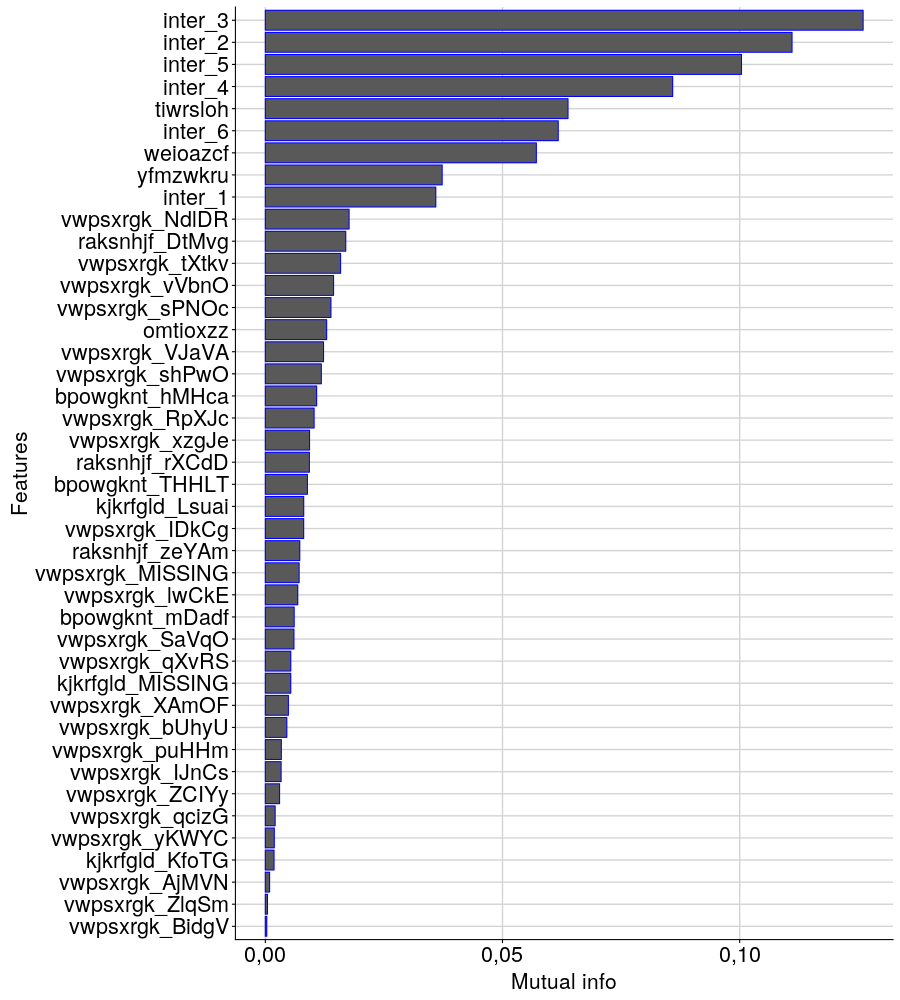

In [40]:
%%R -i dd -w 900 -h 1000 -u px

d = Mutual_info(dd)
print(d)
ggsave('fig/mutual_info_classif.png')




![alt text](fig/trans.png "Title")



In [41]:
# transform the data for training and testing sets (the same functions for both).

#train
dataset_complete = read_csv('data/Exercise_train.csv', sep=',', header=0, low_memory=False)
dataset_complete = dataset_complete.iloc[:,2:11]

#test
datatest = read_csv('data/Exercise_test.csv', sep=',', header=0, low_memory=False)
datatest = datatest.iloc[:,2:11]



In [42]:
train = prepare_data(dataset_complete, ['NULL'])
test = prepare_data(datatest, train.columns)

In [43]:
train_x = train.drop(columns = 'poor')
train_y = train['poor']

test_x = test.drop(columns = 'poor')
test_y = test['poor']

#print(test_x.shape)
#print(train_x.shape)

#print(test_x.columns)
#print(train_x.columns)

## MODELLING

In [44]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [45]:
import os
import subprocess

import pandas as pd
import numpy as np

from time import time
from operator import itemgetter
from scipy.stats import randint

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

#from sklearn.model_selection.train_test_split import cross_val_score
#from sklearn.feature_extraction import DictVectorizer


#  Decision Trees

In [46]:

# RANDON SEARCH

print("-- Random Parameter Search via 10-fold CV")

# dict of parameter list/distributions to sample
param_dist = {"criterion": ["gini", "entropy"],
                  "min_samples_split": randint(5, 20),
                  "max_depth": randint(5, 10),
                  "min_samples_leaf": randint(1, 20),
                  "max_leaf_nodes": randint(10, 20)}
tree = DecisionTreeClassifier()
tree_cv = RandomizedSearchCV(tree, param_dist, cv=10)
X = tree_cv.fit(train_x, train_y)


-- Random Parameter Search via 10-fold CV


In [47]:
print(tree_cv.best_score_)
print(tree_cv.best_params_)
print(tree_cv.best_estimator_)

0.7133495885400792
{'max_depth': 5, 'min_samples_split': 5, 'max_leaf_nodes': 17, 'min_samples_leaf': 13, 'criterion': 'gini'}
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=17,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=13, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


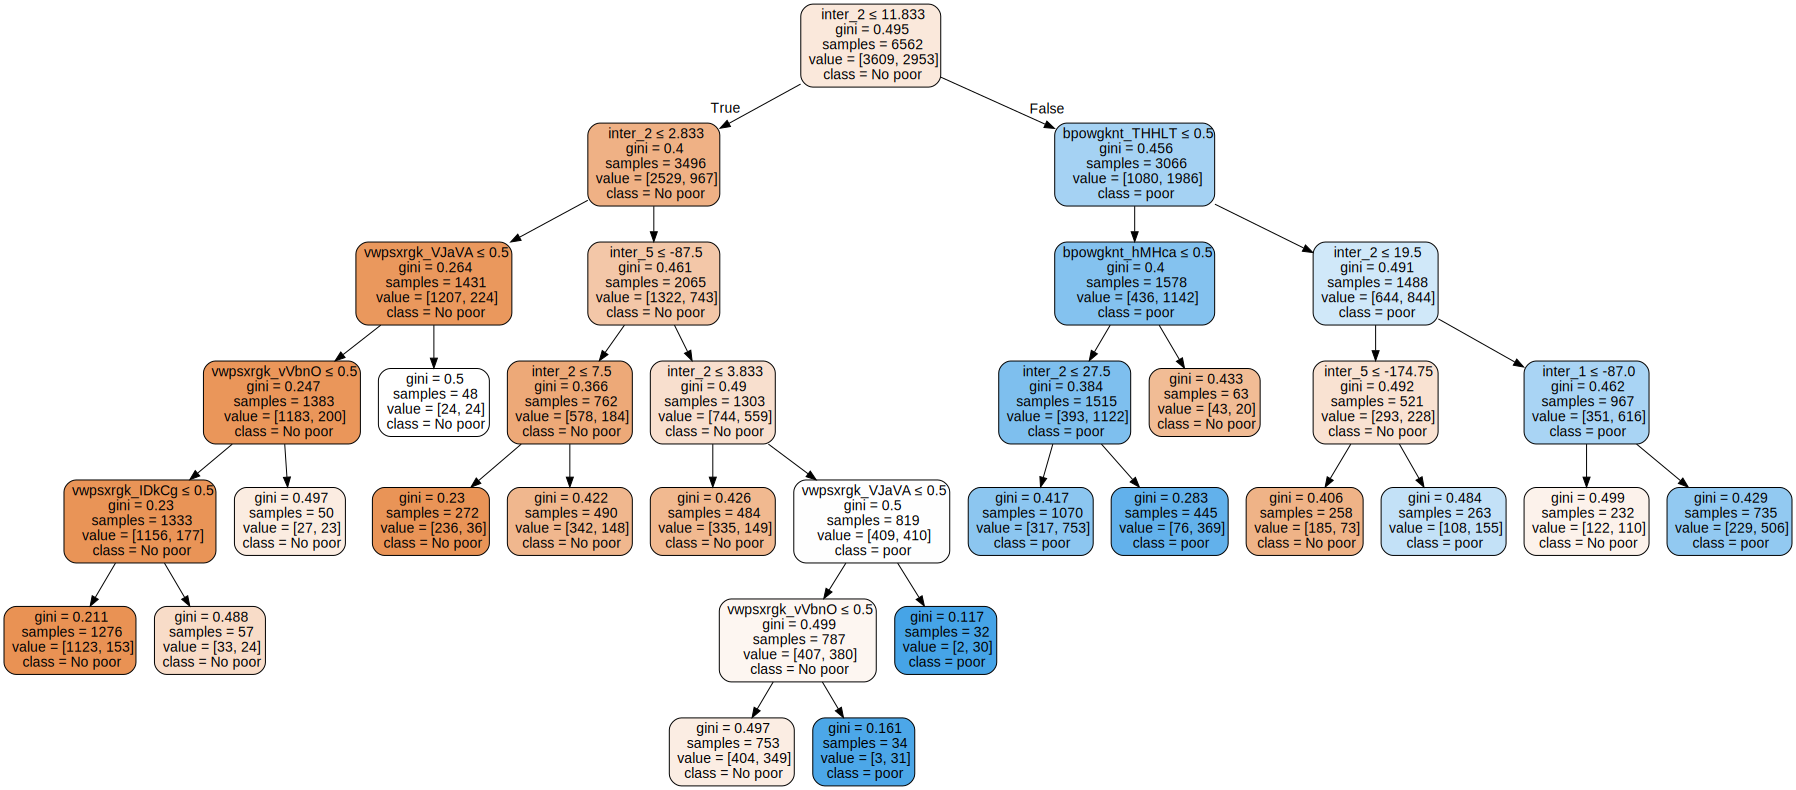

In [48]:
from sklearn import tree
import graphviz 
 
# Create each decision tree (pruned and unpruned)
#decisionTree_unpruned = tree.DecisionTreeClassifier(criterion="entropy")
decisionTree = tree.DecisionTreeClassifier(criterion="gini", max_depth = 5, max_leaf_nodes=17,
                                          min_samples_leaf=13, min_samples_split=5)
 
# Fit each tree to our training data
#decisionTree_unpruned = decisionTree_unpruned.fit(X=train_x, y=train_y)
decisionTree = decisionTree.fit(X=train_x, y=train_y)
 
# Generate PDF visual of decision tree
churnTree = tree.export_graphviz(decisionTree, out_file=None, 
                         feature_names = list(train_x.columns.values),  
                         class_names = ['No poor', 'poor'],
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(churnTree)
#graph.render('fig/decision_tree.gv', view=True)


graph

In [49]:
test_y_pred_dt = decisionTree.predict(test_x)
print('Accuracy of decision tree classifier on test set: {:.2f}'.format(decisionTree.score(test_x, test_y)))

Accuracy of decision tree classifier on test set: 0.69


In [50]:
#test_y_pred_dt
def_metrics(test_y, test_y_pred_dt) 

Recall: 0.5786666666666667
Accuracy: 0.687995124923827
Precision: 0.6888888888888889
F1_score: 0.6289855072463768


In [51]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(test_y, test_y_pred_dt)
#confusion_matrix_df = pd.DataFrame(confusion_matrix, ('No poor', 'poor'), ('No poor', 'poor'))
#heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
#heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
#heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
#plt.ylabel('True label', fontsize = 14)
#plt.xlabel('Predicted label', fontsize = 14)


Normalized confusion matrix
[[0.78002245 0.21997755]
 [0.42133333 0.57866667]]


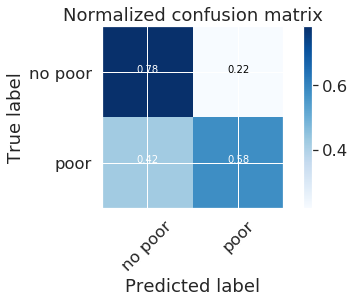

In [52]:
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
class_temp =['no poor', 'poor']
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [53]:
# roc
from sklearn.metrics import roc_curve
fpr_DT, tpr_DT, thresholds_DT =roc_curve(test_y, test_y_pred_dt)



![alt text](fig/models.png "Title")

## LOGISTIC REGRESSION 

In [54]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(train_x, train_y.ravel())
print(rfe.support_)
print(rfe.ranking_)


[False False False False False False False  True False  True False False
 False False False  True  True  True  True  True  True False  True  True
 False  True  True False  True  True False  True  True  True  True False
  True False  True]
[19 17 20 13 15  3 14  1 11  1 10  9 12 18 16  1  1  1  1  1  1  2  1  1
  7  1  1  6  1  1  4  1  1  1  1  5  1  8  1]


In [55]:
#selected variables
cols = train_x.columns[rfe.support_ == True]
X=train_x.loc[:, cols]
y=train_y

import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

# NOTE: ELIMINATE VARIABLES with high p-values

Optimization terminated successfully.
         Current function value: 0.609695
         Iterations 7
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.114      
Dependent Variable: poor             AIC:              8041.6378  
Date:               2019-02-26 18:32 BIC:              8177.4188  
No. Observations:   6562             Log-Likelihood:   -4000.8    
Df Model:           19               LL-Null:          -4515.6    
Df Residuals:       6542             LLR p-value:      2.6204e-206
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
bpowgknt_THHLT     -0.2948   0.0443 -6.6558 0.0000 -0.3816 -0.2080
bpowgknt_hMHca     -1.2827   0.2223 -5.7698 0.0000 -1

The p-values for most of the variables are smaller than 0.05.

### introduce the last results below

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

X=train_x.loc[:, cols]
y=train_y
X_test=test_x.loc[:, cols]

logisticRegr = LogisticRegression()
results =cross_val_score(logisticRegr, X, y, cv=5, scoring='accuracy')
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Results: 65.53% (1.72%)


In [57]:
logisticRegr.fit(X=X, y=y)
test_y_pred = logisticRegr.predict(X_test)
#print('Intercept: ' + str(logisticRegr.intercept_))
#print('Regression: ' + str(logisticRegr.coef_))

Normalized confusion matrix
[[0.69921437 0.30078563]
 [0.43333333 0.56666667]]


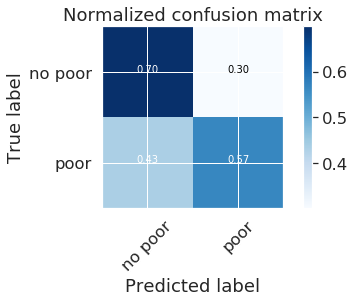

In [58]:
confusion_matrix = confusion_matrix(np.array(test_y), test_y_pred)

import matplotlib.pyplot as plt
# Plot normalized confusion matrix
class_temp =['no poor', 'poor']
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[623 268]
 [325 425]]


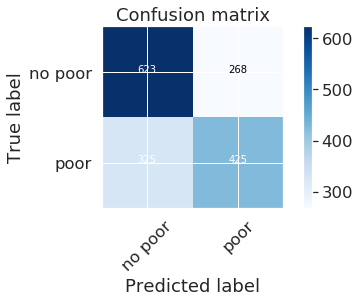

In [59]:
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=False,
                      title='Confusion matrix')

plt.show()

In [60]:
#print(classification_report(np.array(test_y), test_y_pred))
def_metrics(test_y, test_y_pred) 

Recall: 0.5666666666666667
Accuracy: 0.6386349786715417
Precision: 0.6132756132756133
F1_score: 0.5890505890505889


In [61]:
cols = X.columns
coef = pd.DataFrame(logisticRegr.coef_)
coef.columns = cols
coef = coef.transpose()

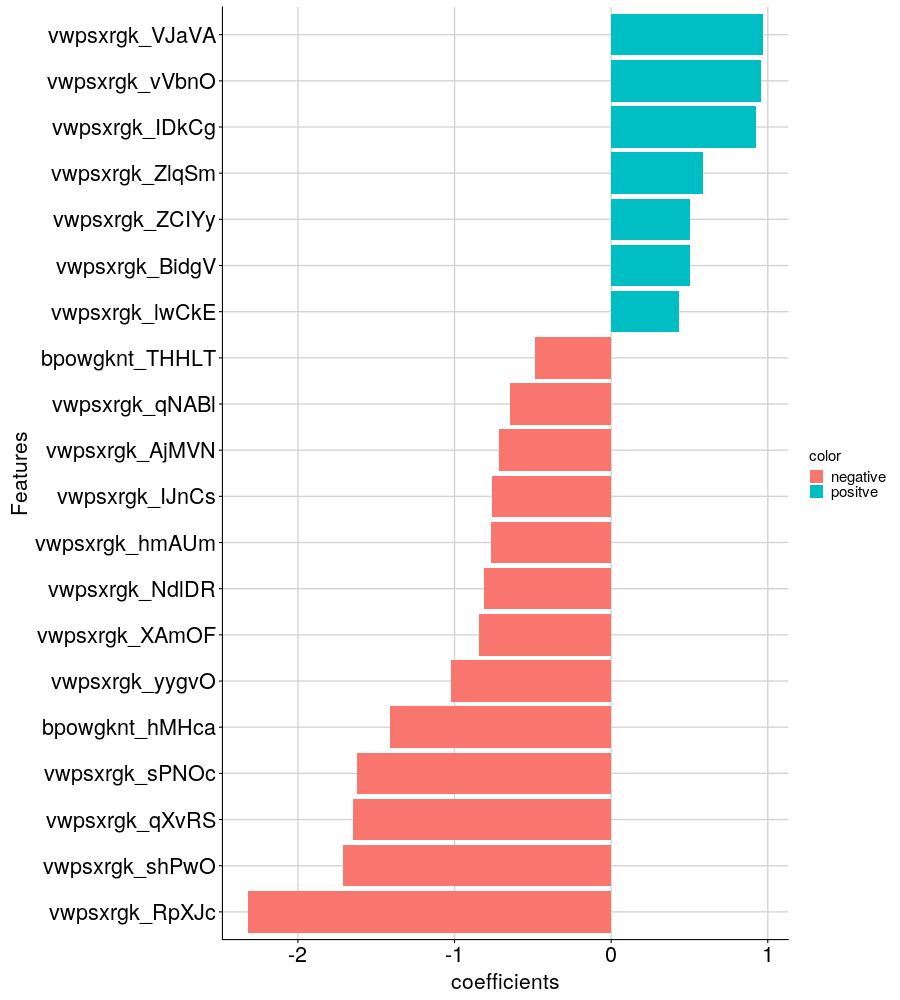

In [62]:
%%R -i coef -w 900 -h 1000 -u px

dt.values = as.data.table(cbind(row.names(coef), coef), row.names = NULL)
names(dt.values) = c('Var1', 'value')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values %>% mutate(color = ifelse(value <= 0,  'negative', 'positve'))

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value), fill = color)) +  geom_bar(stat = "identity") + coord_flip()
d <- d + ylab('coefficients') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/logistic_importance.png')
d

In [63]:
# roc
from sklearn.metrics import roc_curve
fpr_LR, tpr_LR, thresholds_LR =roc_curve(test_y, test_y_pred)


# BOOSTED TREES



In [64]:
from sklearn.ensemble import GradientBoostingClassifier
model_GB= GradientBoostingClassifier(learning_rate=0.01,random_state=1)

# cross vlaidation
results =cross_val_score(model_GB, train_x, train_y, cv=5, scoring='accuracy')
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



/home/erikapat/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Results: 71.53% (1.45%)


In [65]:
model_GB.fit(train_x, train_y)
model_GB.score(test_x, test_y)
importance = pd.Series(model_GB.feature_importances_, train_x.columns).to_frame()#

test_y_pred = model_GB.predict(test_x)

Normalized confusion matrix
[[0.76318743 0.23681257]
 [0.37866667 0.62133333]]


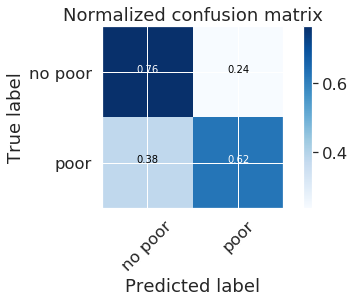

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.array(test_y), np.array(test_y_pred))
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
class_temp =['no poor', 'poor']
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[680 211]
 [284 466]]


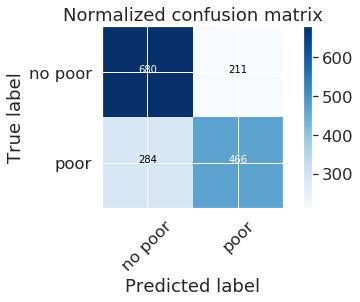

In [67]:
class_temp =['no poor', 'poor']
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

In [68]:
def_metrics(test_y, test_y_pred) 

Recall: 0.6213333333333333
Accuracy: 0.6983546617915904
Precision: 0.6883308714918759
F1_score: 0.6531184302733006


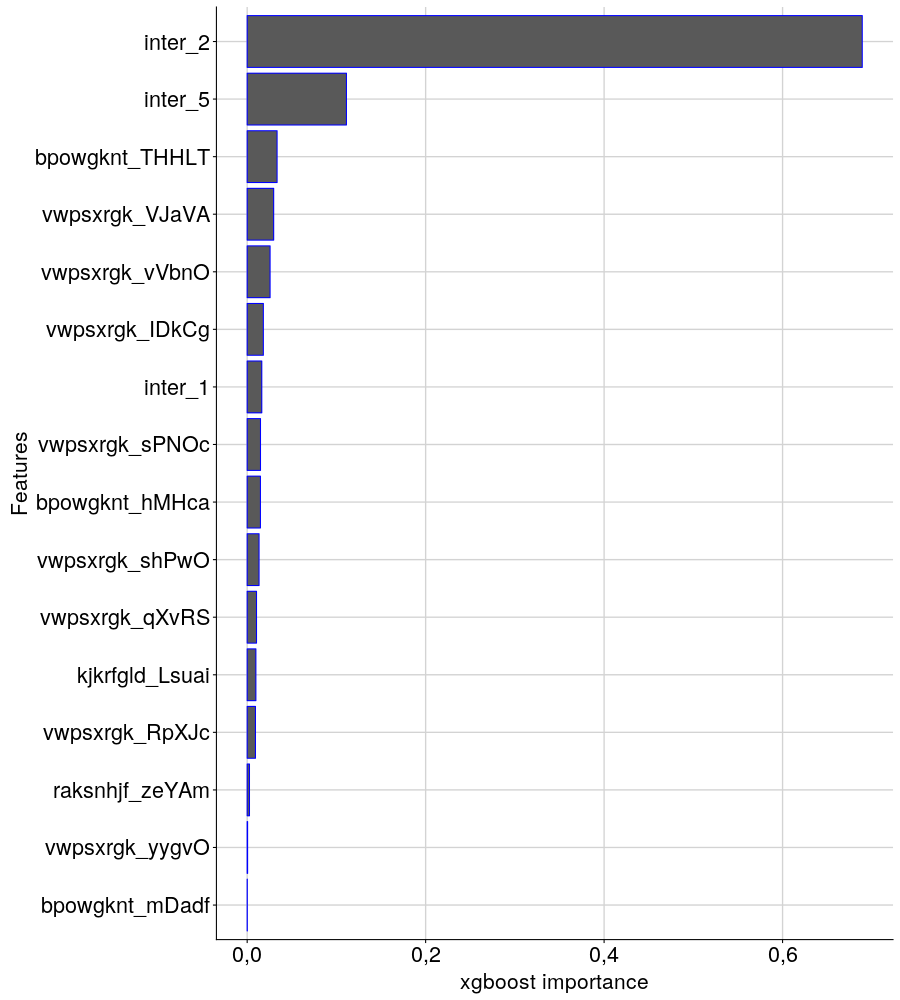

In [69]:
%%R -i importance -w 900 -h 1000 -u px

dt.values = as.data.table(cbind(row.names(importance), importance), row.names = NULL)
names(dt.values) = c('Var1', 'value')
dt.values = dt.values[order(value, decreasing = T),]
dt.values = dt.values[value > 0,]

d <- ggplot(dt.values, aes(y = value, x = reorder(Var1, value))) +  geom_bar(stat = "identity", color = 'blue') + coord_flip()
d <- d + ylab('xgboost importance') + xlab('Features') 
  #d <- d +  theme_tq() 
d <- d + theme(axis.title.y = element_text(size = rel(1.5)))
d <- d + theme(axis.text.y = element_text(size = rel(1.8)))
d <- d + theme(axis.text.x = element_text(size = rel(1.8)))
d <- d + theme(axis.title.x = element_text(size = rel(1.5)))
d <- d + theme(legend.text = element_text(size = 15))
d <- d + theme(legend.title = element_text(size = 15))
d <- d +  theme(
    panel.background = element_rect(fill="white") ,
    panel.grid.minor.y = element_line(size=3),
    panel.grid.major = element_line(colour = "lightgray"),
    plot.background = element_rect(fill="white")
  )

ggsave('fig/xgboost_importance.png')
d

In [70]:
# roc
from sklearn.metrics import roc_curve
fpr_BT, tpr_BT, thresholds_BT =roc_curve(test_y, test_y_pred)

# KERAS - FeedForward NN

In [71]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1) # NumPy
import random
random.seed(2) # Python
from tensorflow import set_random_seed
set_random_seed(2)



X = train_x
Y = train_y
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

## test

X_test = test_x

scaler = MinMaxScaler(feature_range=(0, 1))
X_test = scaler.fit_transform(X_test)
X_test


Using TensorFlow backend.


array([[0.6547619 , 0.30681818, 0.83746998, ..., 0.        , 0.        ,
        0.        ],
       [0.73809524, 0.34090909, 0.78142514, ..., 0.        , 0.        ,
        0.        ],
       [0.42857143, 0.54545455, 0.73458767, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.76190476, 0.03409091, 0.92433947, ..., 0.        , 0.        ,
        0.        ],
       [0.57142857, 0.63636364, 0.75340272, ..., 0.        , 0.        ,
        0.        ],
       [0.80952381, 0.25      , 0.86028823, ..., 0.        , 0.        ,
        0.        ]])

In [81]:
# Baseline model for the neural network. We choose a hidden layer of 10 neurons. The lesser number of neurons helps to eliminate the redundancies in the data and select the more important features.
def create_baseline():
    # create model
    model = Sequential()
    n_layer = 10 #27
    model.add(Dense(n_layer, input_dim= len(train_x.columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_baseline_2():
    # create model
    model = Sequential()
    n_layer = 27
    model.add(Dense(n_layer, input_dim= len(train_x.columns), kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [73]:
# Evaluate model using standardized dataset. 
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True) #10
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 74.14% (0.79%)


In [74]:
#seed = 7
#np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1) # NumPy
import random
random.seed(2) # Python
from tensorflow import set_random_seed
set_random_seed(2)

model = Sequential()
n_layer = 10 #27
model.add(Dense(n_layer, input_dim= len(train_x.columns), kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model. We use the the logarithmic loss function, and the Adam gradient optimizer.
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X, encoded_Y, epochs=100, batch_size=5, verbose=0)
cl = model.predict(X)

In [75]:
#train
cl[cl >=0.5] = 1
cl[cl <0.5]  = 0
train_y_pred=pd.DataFrame(cl)
def_metrics(train_y, train_y_pred) 

Recall: 0.77683711479851
Accuracy: 0.7581530021334959
Precision: 0.7119801365611421
F1_score: 0.742995951417004


In [76]:
np.random.seed(1) # NumPy
import random
random.seed(2) # Python
from tensorflow import set_random_seed
set_random_seed(2)
#test
cl = model.predict(X_test)
cl[cl >=0.5] = 1
cl[cl <0.5]  = 0
test_y_pred=pd.DataFrame(cl)
def_metrics(test_y, test_y_pred) 

Recall: 0.8026666666666666
Accuracy: 0.7117611212675198
Precision: 0.6494066882416397
F1_score: 0.7179487179487181


Normalized confusion matrix
[[0.6352413  0.3647587 ]
 [0.19733333 0.80266667]]


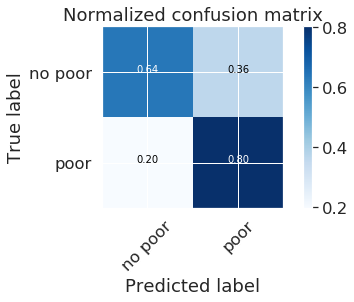

In [77]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(np.array(test_y), np.array(test_y_pred))
import matplotlib.pyplot as plt
# Plot normalized confusion matrix
class_temp =['no poor', 'poor']
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[566 325]
 [148 602]]


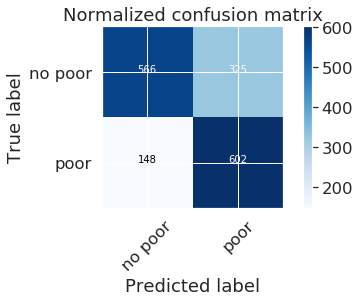

In [78]:
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=class_temp, normalize=False,
                      title='Normalized confusion matrix')

plt.show()

In [79]:
# roc
from sklearn.metrics import roc_curve
fpr_NN, tpr_NN, thresholds_NN =roc_curve(test_y, test_y_pred)

#### Other models for keras (not used)

In [82]:
# Evaluate model using standardized dataset. 
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasClassifier(build_fn=create_baseline_2, epochs=100, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = StratifiedKFold(n_splits=5, shuffle=True) #10
results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 72.95% (1.03%)


## ROC of all models

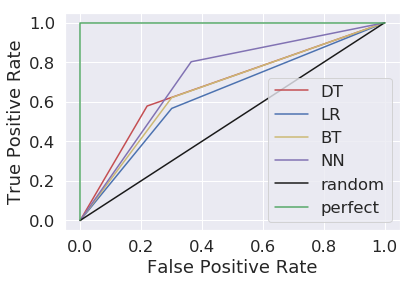

In [80]:
## ROC

import matplotlib.pyplot as plt
plt.plot(fpr_DT, tpr_DT,'r-',label = 'DT')
plt.plot(fpr_LR,tpr_LR,'b-', label= 'LR')
plt.plot(fpr_LR,tpr_BT,'y-', label= 'BT')
plt.plot(fpr_NN,tpr_NN,'m-', label= 'NN')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()



# EMSEMBLERS

We can try other models and select and combine those that help us to improve the results, there are several methodologies for this. We summarize some of them in the following figure.

![alt text](fig/ensemble.png "Title")

## CONCLUSION

The conclusion of this analysis can be found in Poverty_prediction_problem.pdf